TUTORIAL 5 : CO2 adsorption in a zeolite
========================================

Original authors: James Grant (r.j.grant{at}bath.ac.uk), Tom L. Underwood (t.l.underwood{at}bath.ac.uk)

Modified to use dlmontepython by Joe Manning (joseph.manning{at}manchester.ac.uk)

Introduction
------------

In this exercise you will evaluate the amount of $CO_2$ adsorbed in a siliceous zeolite under certain conditions.
We use a Grand Canonical Monte Carlo simulation, in which Monte Carlo moves are performed which insert and remove $CO_2$ molecules from the system, alongside translational moves to explore the local environment.
After a certain amount of simulation time, the number of $CO_2$ molecules will reflect the equilibrium concentration within the zeolite.
You will examine the length of time required to run simulations under different conditions and how to analyse the data in order to construct an adsorption isotherm.
Of course, there will be fluctuations in the number of $CO_2$ molecules about the 'true' average which you can also investigate.

CONFIG
------

As always the CONFIG file contains the starting structure. 
If you examine the file you will see that the system contains two 'molecule' types: 
'zeolite', which contains silcon and oxygen atoms (labeled Si_S and O_S) making up the zeolite, and 'co2', which contains C (labeled C_) and O (labeled O_C). 
Initially, we have an empty 'zeolite' molecule  only.
Your first objective is to visualise the structure and identify the different pore spaces. We can do this with [ASE](https://wiki.fysik.dtu.dk/ase/#).

In [20]:
from ase import Atoms
from ase.visualize import view
from scripts import ase_hack

with open('./Tutorial_5_files/CONFIG', 'r') as f:
    in_data = ase_hack.read_dlm(f)
    framework = next(in_data)[0][1]
    
view(framework)

<Popen: returncode: None args: ['C:\\Users\\d23895jm\\Anaconda3\\envs\\dlmon...>

FIELD
-----

The FIELD file is shown below:

```
   Force fields and bond constraints for for CO2 in a zeolite (use EPM2 for VDW)
   CUTOFF 12.0
   UNITS kcal
   NCONFIGS 1
   ATOMS 5
   Si_S core 28 2.4
   O_S core 16 -1.2
   C_ core 12 0.6512
   O_C core 16 -0.3256
   MOLTYPES 2
   zeolite
   MAXATOM 584
   co2
   ATOMS 3 3
   C_ core  0.00000000 0.0000000 0.0000000
   O_C core 1.16300000 0.0000000 0.0000000
   O_C core -1.16300000 0.0000000 0.0000000
   BONDS 3
      1    2    1
      1    3    1
      2    3    2
   FINISH
   VDW       6
   O_ core       C_ core       lj    0.094566874 2.892
   O_ core       O_C core      lj    0.15998351 3.033
   C_ core       C_ core       lj    0.055892323 2.757
   C_ core       O_C core      lj    0.094566874 2.892
   O_C core      O_C core      lj    0.15998351 3.033
   BONDS 2
   C_ core O_C core buck 0.0 0.1 0.0
   O_C core O_C core buck 0.0 0.1 0.0
   CLOSE
```
The first thing to note is that this system has charged atoms: 
Si and O\_ in the zeolite, C and O in $CO_2$, and Xe, are assigned net charges of 2.4, -1.2, 0.72, -0.36 and 0 respectively.
The Si and O\_ potential is based on the [BKS](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.64.1955) potential.  
Formally this uses a Buckingham potential but in this instance, for the purpose of generating cross terms for interaction with the $CO_2$ model, this has been fitted with a Lennard-Jones potential. 
The $CO_2$ is modelled with the [EPM](https://pubs.acs.org/doi/10.1021/j100031a034) model.
The final vdw interaction is between the $CO_2$ oxygen atoms and the 'xenon' particles.
These only have a strong repulsive interaction with the $CO_2$ oxygens.

CONTROL
-------

The CONTROL file is shown below:

```
   GCMC simulation of CO2 in zeolite
   use gaspressure              # input is in partial pressure in GCMC moves 
                                # (as opposed to chemical potential)
   finish
   temperature       273.0
   acceptmolmoveupdate  200     # Period (in moves) at which the
                                # maximum move size is recalculated
   acceptmolrotupdate  200      # Period (in moves) at which the 
                                # maximum rotation angle is updated
   steps             100000     # Number of moves to perform in simulation
   equilibration     50000      # Equilibration time before statistics 
                                # are gathered (in moves)
   print               1000     # Information is output every 'print' moves
   revconformat dlmonte         # REVCON file is in DL_POLY CONFIG format
   archiveformat dlpoly4        # ARCHIVE/trajectory file format
                                # NB. No support yet for GCMC tracjectories
   stack              10000     # Size of blocks (in moves) for block averaging
   maxmolrot           0.005    # Initial maximum rotation angle (degrees)
   yamldata           1000
   move molecule 1 20           # Perform translation moves for 
                                # 1 molecule type weight 20
   co2                          # move co2 molecule type
   move rotatemol 1 20          # Perform rotation moves for 
                                # 1 molecule type weight 20
   co2                          # rotate co2 molecule type
   move gcinsertmol 1 60 0.5    # Perform insertion/removal moves 
                                # with 1 molecule type weight 60
                                # with a min. distance of 0.5 from existing
                                # atoms for inserts
   co2 0.0001                   # Insert/remove CO2 with a 
                                # partial pressure of 0.0001 katm
   start
```

Note that we are now using *molecular* moves which translate (*move molecule*) and rotate (*move rotatemol*) the CO2 molecules, but we do not use *atomic* moves which translate the atoms within the molecules.
The CO2 are therefore considered as rigid molecules during the simulation. This restriction typically has to be in place for standard GCMC in order to satisfy detailed balance.
GC moves are introduced by the *move gcinsertmol* directive.
As with the other move types the first number is the number of molecules we will be inserting/deleting and the second is the weight given to GC moves.
An additional feature is the ability to automatically reject moves with would result in any atom of the molecule lying within a specified distance of any atom already in the system.
In order to satisfy detailed balance this should be smaller than the closest distance you would expect atoms to approach.

### Exercise 1: run a simulation at the first pressure point and calculate the equilibium concentration

Mean adsorbed amount: 3.870 ± 1.809


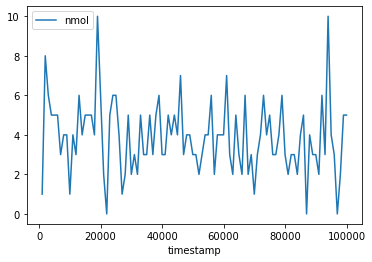

In [37]:
from dlmontepython.htk.sources import dlptfile
import pandas as pd
import numpy as np
from pymbar import timeseries

# Your code here!
yaml_out = dlptfile.load_yaml('./Tutorial_5_files/')
yaml_df = pd.DataFrame(yaml_out.data)
yaml_df.nmol = yaml_df['nmol'].apply(lambda x: int(x[1]))
yaml_df = yaml_df.set_index('timestamp')
yaml_df.plot.line(y='nmol')

t0, g, Neff_max = timeseries.detectEquilibration(yaml_df['nmol']) # compute indices of uncorrelated timeseries
A_t_equil = np.array(yaml_df['nmol'][t0:])
indices = timeseries.subsampleCorrelatedData(A_t_equil, g=g)
A_n = A_t_equil[indices]
print(f'Mean adsorbed amount: {np.mean(A_n):.3f} ± {np.std(A_n):.3f}')

Partial Pressure, Activity and Chemical Potential
-------------------------------------------------

The *use gaspressure* directive specified at the beginning of the CONTROL file means that the partial pressure of the gas, rather than the activity is specified.

$$
a = \gamma \frac{P}{P_0},
$$
where $a$ is the activity, $\gamma=1$ is the gas fraction assumed to be *1*, and $P$ and $P_0$ the pressure and reference pressure respectively.
Note that DL_MONTE introduces a further converesion factor, dividing by 0.163882576 to convert to internal units.

The activity relates to chemical potential according to

$$
    a = \exp((\mu - \mu_0)/RT)
$$
where $\mu$ and $\mu_0$ are the chemical potential and refernce chemical potential, *R* gas constant and *T* temperature.

### Exercise 2: Trace an Adsorption Isotherm

We are interested in the number of adsorbed $CO_2$ molecules as a function of pressure. Using the code from exercise 1, can you rerun the simulation at several fugacity values and to calculate the total isotherm?

At the initial conditions specified in the CONTROL file, the number of adsorbed molecules is small because this corresponds to a relatively low partial pressure of $CO_2$.
As we increase the partial pressure the number of $CO_2$ molecules adsorbed will increase.
Making sure you copy your output to different folders for each calculation. Increase the partial pressure until the zeolite is saturated.
Compare the time sequences and final averages and fluctuations to make an initial estimate of the adsorption isotherm.

What do these initial results show would you need to consider to ensure the accuracy of your calcuation?